In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import re
from torch.utils.data import Dataset
import csv
import torchvision
from PIL import Image

torch.cuda.empty_cache()

/home/venkat/anaconda3/envs/multihead/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [3]:
import torch
import torchvision
print(torch.cuda.is_available())

True


# Dataset Preparation

In [4]:
class AttributesDataset():
    def __init__(self, annotation_path):
        species_labels = []
        gender_labels = []
        abdomen_labels = []

        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                species_labels.append(row['label'])
                gender_labels.append(row['gender'])
                abdomen_labels.append(row['abdomen'])

        self.species_labels = np.unique(species_labels)
        self.gender_labels = np.unique(gender_labels)
        self.abdomen_labels = np.unique(abdomen_labels)

        self.num_species = len(self.species_labels)
        self.num_genders = len(self.gender_labels)
        self.num_abdomen = len(self.abdomen_labels)

        self.species_id_to_name = dict(zip(range(len(self.species_labels)), self.species_labels))
        self.species_name_to_id = dict(zip(self.species_labels, range(len(self.species_labels))))

        self.gender_id_to_name = dict(zip(range(len(self.gender_labels)), self.gender_labels))
        self.gender_name_to_id = dict(zip(self.gender_labels, range(len(self.gender_labels))))

        self.abdomen_id_to_name = dict(zip(range(len(self.abdomen_labels)), self.abdomen_labels))
        self.abdomen_name_to_id = dict(zip(self.abdomen_labels, range(len(self.abdomen_labels))))


class MosquitoDataset(Dataset):
    def __init__(self, annotation_path, attributes, transform=None):
        super().__init__()

        self.transform = transform
        self.attr = attributes

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data = []
        self.species_labels = []
        self.gender_labels = []
        self.abdomen_labels = []

        # read the annotations from the CSV file
        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row['path'])
                self.species_labels.append(self.attr.species_name_to_id[row['label']])
                self.gender_labels.append(self.attr.gender_name_to_id[row['gender']])
                self.abdomen_labels.append(self.attr.abdomen_name_to_id[row['abdomen']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data[idx]
        
        data_input_path = "/home/venkat/Venkat/Multi-Label Classifcation/dataset/"
        img_path = data_input_path + str(img_path)

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and all the associated labels
        dict_data = {
            'img': img,
            'labels': {
                'species_labels': self.species_labels[idx],
                'gender_labels': self.gender_labels[idx],
                'abdomen_labels': self.abdomen_labels[idx]
            }
        }
        return dict_data

In [5]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class MultiOutputModel(nn.Module):
    def __init__(self, n_species_classes, n_gender_classes, n_abdomen_classes):
        super().__init__()
        self.base_model = models.efficientnet_b1().features  # take the model without classifier
#         last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier
#         self.model_wo_fc = nn.Sequential(*(list(self.base_model.children())[:-1]))
        last_channel = 1280

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.species = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_species_classes)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_gender_classes)
        )
        self.abdomen = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_abdomen_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        
#         x = self.model_wo_fc(x)
        # x = torch.flatten(x, 1)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'species': self.species(x),
            'gender': self.gender(x),
            'abdomen': self.abdomen(x)
        }

    def get_loss(self, net_output, ground_truth):
        species_loss = F.cross_entropy(net_output['species'], ground_truth['species_labels'])
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender_labels'])
        abdomen_loss = F.cross_entropy(net_output['abdomen'], ground_truth['abdomen_labels'])
        loss = species_loss + gender_loss + abdomen_loss
        return loss, {'species': species_loss, 'gender': gender_loss, 'abdomen': abdomen_loss}

# Training

In [6]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

def calculate_metrics(output, target):
    _, predicted_species = output['species'].cpu().max(1)
    gt_species = target['species_labels'].cpu()

    _, predicted_gender = output['gender'].cpu().max(1)
    gt_gender = target['gender_labels'].cpu()

    _, predicted_abdomen = output['abdomen'].cpu().max(1)
    gt_abdomen = target['abdomen_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_species = accuracy_score(y_true=gt_species.numpy(), y_pred=predicted_species.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_abdomen = accuracy_score(y_true=gt_abdomen.numpy(), y_pred=predicted_abdomen.numpy())

    return accuracy_species, accuracy_gender, accuracy_abdomen

In [7]:

%matplotlib inline
import matplotlib.pyplot as plt

def visualize_gt_data(dataset, attributes):
    imgs = []
    gt_labels = []

    n_cols = 5
    n_rows = 3

    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for img_idx in range(n_cols * n_rows):
        sample = dataset[img_idx]
        img = sample['img']
        labels = sample['labels']
        gt_species = attributes.species_id_to_name[labels['species_labels']]
        gt_gender = attributes.gender_id_to_name[labels['gender_labels']]
        gt_abdomen = attributes.abdomen_id_to_name[labels['abdomen_labels']]
        
        imgs.append(img)
        gt_labels.append("{}\n{}\n{}".format(gt_species, gt_gender, gt_abdomen))

    title = "Ground truth labels"

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, gt_labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # restore original transforms


In [8]:
def checkpoint_load(model, name):
    print('Restoring checkpoint: {}'.format(name))
    model.load_state_dict(torch.load(name, map_location='cpu'))
    epoch = int(os.path.splitext(os.path.basename(name))[0].split('-')[1])
    return epoch

In [9]:
def net_output_to_predictions(output):
    _, predicted_species = output['species'].cpu().max(1)
    _, predicted_genders = output['gender'].cpu().max(1)
    _, predicted_abdomen = output['abdomen'].cpu().max(1)

    return predicted_species.numpy().tolist(), predicted_genders.numpy().tolist(), predicted_abdomen.numpy().tolist()


In [10]:
def validate(model, dataloader, device, logger=None, epoch=None, checkpoint=None):
    if checkpoint is not None:
        checkpoint_load(model, checkpoint)

    model.eval()
    species_predictions = []
    gender_predictions = []
    abdomen_predictions = []
    with torch.no_grad():
        avg_loss = 0
        accuracy_species = 0
        accuracy_gender = 0
        accuracy_abdomen = 0

        for batch in dataloader:
            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            val_train, val_train_losses = model.get_loss(output, target_labels)
            avg_loss += val_train.item()
            batch_accuracy_species, batch_accuracy_gender, batch_accuracy_abdomen = \
                calculate_metrics(output, target_labels)

            accuracy_species += batch_accuracy_species
            accuracy_gender += batch_accuracy_gender
            accuracy_abdomen += batch_accuracy_abdomen

            (batch_species_predictions,
             batch_gender_predictions,
             batch_abdomen_predictions) = net_output_to_predictions(output)

            species_predictions.extend(batch_species_predictions)
            gender_predictions.extend(batch_gender_predictions)
            abdomen_predictions.extend(batch_abdomen_predictions)

    n_samples = len(dataloader)
    avg_loss /= n_samples
    accuracy_species /= n_samples
    accuracy_gender /= n_samples
    accuracy_abdomen /= n_samples
    print('-' * 72)
    print("Validation  loss: {:.4f}, species: {:.4f}, gender: {:.4f}, abdomen: {:.4f}\n".format(
        avg_loss, accuracy_species, accuracy_gender, accuracy_abdomen))

    if logger is not None and epoch is not None:
        logger.add_scalar("val_loss", avg_loss, epoch)
        logger.add_scalar("val_accuracy/species", accuracy_species, epoch)
        logger.add_scalar("val_accuracy/gender", accuracy_gender, epoch)
        logger.add_scalar("val_accuracy/abdomen", accuracy_abdomen, epoch)
    model.train()

    return species_predictions, gender_predictions, abdomen_predictions

In [11]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    


def train(start_epoch=1, N_epochs=50, batch_size=8, num_workers=8):
    attributes_file = '/home/venkat/Venkat/Multi-Label Classifcation/dataset/CV_1/train_datapath_fold1.csv'
    device = torch.device("cuda")

    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # specify image transforms for augmentation during training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(degrees=(-45,45)),
        transforms.RandomPerspective(distortion_scale=0.2),
#         transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
#                                 shear=None, resample=False, fillcolor=(255, 255, 255)),
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
#         transforms.Normalize(mean, std)
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        ),
    ])

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        ),
    ])

    train_dataset = MosquitoDataset('/home/venkat/Venkat/Multi-Label Classifcation/dataset/CV_1/train_datapath_fold1.csv', attributes, train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = MosquitoDataset('/home/venkat/Venkat/Multi-Label Classifcation/dataset/CV_1/val_datapath_fold1.csv', attributes, val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = MultiOutputModel(n_species_classes=attributes.num_species,
                             n_gender_classes=attributes.num_genders,
                             n_abdomen_classes=attributes.num_abdomen)\
                            .to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(),lr = 0.001, weight_decay = 1e-5)

    logdir = os.path.join('logs', get_cur_time())
    print(logdir)
    savedir = os.path.join('checkpoints', get_cur_time())
    print(savedir)
    os.makedirs(logdir, exist_ok=False)
    os.makedirs(savedir, exist_ok=False)
    logger = SummaryWriter(logdir)

    n_train_samples = len(train_dataloader)

    
    visualize_gt_data(val_dataset, attributes)
    print("\nAll gender labels:\n", attributes.gender_labels)
    print("\nAll species labels:\n", attributes.species_labels)
    print("\nAll abdomen labels:\n", attributes.abdomen_labels)

    print("Starting training ...")

    checkpoint_path = None
    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_species = 0
        accuracy_gender = 0
        accuracy_abdomen = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))
#             output = model(img).to(device)

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_species, batch_accuracy_gender, batch_accuracy_abdomen = \
                calculate_metrics(output, target_labels)

            accuracy_species += batch_accuracy_species
            accuracy_gender += batch_accuracy_gender
            accuracy_abdomen += batch_accuracy_abdomen

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d}, loss: {:.4f}, species: {:.4f}, gender: {:.4f}, abdomen: {:.4f}".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_species / n_train_samples,
            accuracy_gender / n_train_samples,
            accuracy_abdomen / n_train_samples))

        logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 25 == 0:
            checkpoint_path = checkpoint_save(model, savedir, epoch)

#         if epoch % 5 == 0:
#             validate(model, val_dataloader, device, logger, epoch)
            
    checkpoint_path = checkpoint_save(model, savedir, epoch - 1)

    return checkpoint_path

logs/2022-05-25_22-08
checkpoints/2022-05-25_22-08


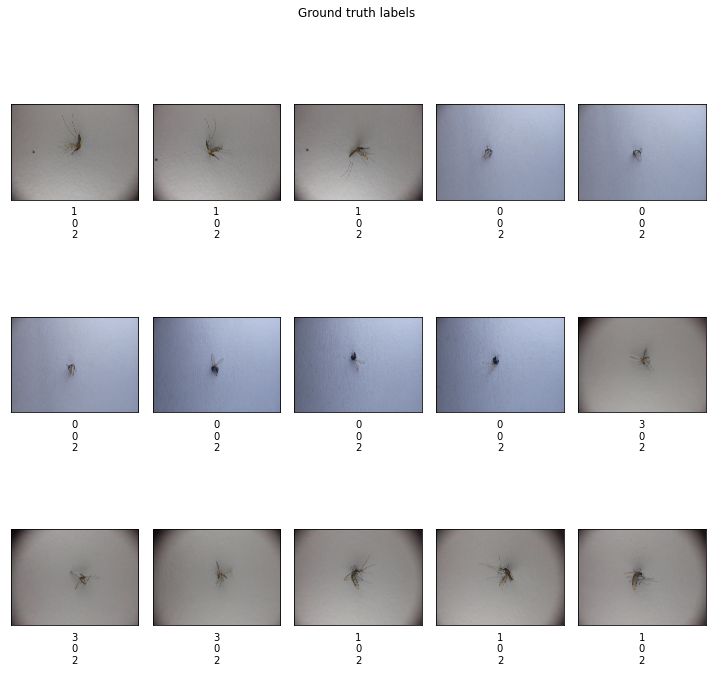


All gender labels:
 ['0' '1']

All species labels:
 ['0' '1' '2' '3']

All abdomen labels:
 ['0' '1' '2' '3']
Starting training ...
epoch    1, loss: 2.3218, species: 0.3613, gender: 0.7988, abdomen: 0.8827
epoch    2, loss: 2.0793, species: 0.4977, gender: 0.8088, abdomen: 0.8938
epoch    3, loss: 2.0483, species: 0.4812, gender: 0.8074, abdomen: 0.8955
epoch    4, loss: 2.0233, species: 0.5071, gender: 0.8114, abdomen: 0.8970
epoch    5, loss: 1.9531, species: 0.5225, gender: 0.8119, abdomen: 0.8973
epoch    6, loss: 1.9262, species: 0.5337, gender: 0.8122, abdomen: 0.8973
epoch    7, loss: 1.8900, species: 0.5485, gender: 0.8076, abdomen: 0.8973
epoch    8, loss: 1.8762, species: 0.5736, gender: 0.8096, abdomen: 0.8973
epoch    9, loss: 1.8287, species: 0.5688, gender: 0.8102, abdomen: 0.8973
epoch   10, loss: 1.8226, species: 0.5631, gender: 0.8108, abdomen: 0.8970
epoch   11, loss: 1.7945, species: 0.5674, gender: 0.8128, abdomen: 0.8973
epoch   12, loss: 1.7919, species: 0.5679,

In [12]:
last_checkpoint_path = train()

# Testing

In [16]:
# from test.py
%matplotlib inline
import argparse
import os


import numpy as np
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import seaborn as sn


def visualize_grid(dataset, attributes, species_predictions, gender_predictions, abdomen_predictions):
    imgs = []
    labels = []
    predicted_species_all = []
    predicted_gender_all = []
    predicted_abdomen_all = []

    gt_labels = []
    gt_species_all = []
    gt_gender_all = []
    gt_abdomen_all = []

    
    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for (sample, 
         predicted_species, 
         predicted_gender, 
         predicted_abdomen) in zip(
             dataset, species_predictions, gender_predictions, abdomen_predictions):
        predicted_species = attributes.species_id_to_name[predicted_species]
        predicted_gender = attributes.gender_id_to_name[predicted_gender]
        predicted_abdomen = attributes.abdomen_id_to_name[predicted_abdomen]

        gt_species = attributes.species_id_to_name[sample['labels']['species_labels']]
        gt_gender = attributes.gender_id_to_name[sample['labels']['gender_labels']]
        gt_abdomen = attributes.abdomen_id_to_name[sample['labels']['abdomen_labels']]

        predicted_species_all.append(predicted_species)
        predicted_gender_all.append(predicted_gender)
        predicted_abdomen_all.append(predicted_abdomen)

        gt_species_all.append(gt_species)
        gt_gender_all.append(gt_gender)
        gt_abdomen_all.append(gt_abdomen)

        imgs.append(sample['img'])
        labels.append("{}\n{}\n{}".format(predicted_species, predicted_gender, predicted_abdomen))
        gt_labels.append("{}\n{}\n{}".format(gt_species, gt_gender, gt_abdomen))

    # restore original transforms
    dataset.transform = transforms

    # Draw confusion matrices
    # species
    cn_matrix = confusion_matrix(
        y_true=gt_species_all,
        y_pred=predicted_species_all,
        labels=attributes.species_labels,
        normalize='true')
    print("************Species**********")
    print(classification_report(gt_species_all, predicted_species_all))
    
    conf_mat = cn_matrix / np.expand_dims(cn_matrix.astype(np.float64).sum(axis=1),1)
    conf_mat = np.round(conf_mat, decimals=2)
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
    ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
    ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
    ax.xaxis.set_ticklabels(attributes.species_labels); ax.yaxis.set_ticklabels(attributes.species_labels)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
#     plt.savefig('/content/drive/MyDrive/CBID/EfficientNet/Species_EfficientNet_perspective.jpg')
    plt.show();
    
    
    
#     plt.rcParams.update({'font.size': 5})
#     plt.rcParams.update({'figure.dpi': 300})
#     ConfusionMatrixDisplay(cn_matrix, attributes.species_labels).plot(include_values=False, xticks_rotation='vertical')
#     plt.title("Species")
#     plt.tight_layout()
#     plt.show()

    # gender
    cn_matrix = confusion_matrix(
        y_true=gt_gender_all,
        y_pred=predicted_gender_all,
        labels=attributes.gender_labels,
        normalize='true')
    
    
    print("************Gender**********")
    print(classification_report(gt_gender_all, predicted_gender_all))
    
    conf_mat = cn_matrix / np.expand_dims(cn_matrix.astype(np.float64).sum(axis=1),1)
    conf_mat = np.round(conf_mat, decimals=2)
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
    ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
    ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
    ax.xaxis.set_ticklabels(attributes.gender_labels); ax.yaxis.set_ticklabels(attributes.gender_labels)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
#     plt.savefig('/content/drive/MyDrive/CBID/EfficientNet/Species_EfficientNet_perspective.jpg')
    plt.show();
    
#     ConfusionMatrixDisplay(cn_matrix, attributes.gender_labels).plot(xticks_rotation='horizontal')
#     plt.title("Genders")
#     plt.tight_layout()
#     plt.show()

    plt.rcParams.update({'font.size': 2.5})
    cn_matrix = confusion_matrix(
        y_true=gt_abdomen_all,
        y_pred=predicted_abdomen_all,
        labels=attributes.abdomen_labels,
        normalize='true')
#     ConfusionMatrixDisplay(cn_matrix, attributes.abdomen_labels).plot(include_values=False, xticks_rotation='vertical')
#     plt.title("Abdomen")
#     plt.show()

#     plt.rcParams.update({'font.size': 5})
#     plt.rcParams.update({'figure.dpi': 100})
#     title = "Predicted labels"
#     n_cols = 5
#     n_rows = 3
#     fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
#     axs = axs.flatten()
#     for img, ax, label in zip(imgs, axs, labels):
#         ax.set_xlabel(label, rotation=0)
#         ax.get_xaxis().set_ticks([])
#         ax.get_yaxis().set_ticks([])
#         ax.imshow(img)
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()
    print("************Abdomen**********")
    print(classification_report(gt_abdomen_all, predicted_abdomen_all))
    
    conf_mat = cn_matrix / np.expand_dims(cn_matrix.astype(np.float64).sum(axis=1),1)
    conf_mat = np.round(conf_mat, decimals=2)
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
    ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
    ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
    ax.xaxis.set_ticklabels(attributes.abdomen_labels); ax.yaxis.set_ticklabels(attributes.abdomen_labels)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
#     plt.savefig('/content/drive/MyDrive/CBID/EfficientNet/Species_EfficientNet_perspective.jpg')
    plt.show();



def test(checkpoint_path):
    attributes_file = '/home/venkat/Venkat/Multi-Label Classifcation/dataset/CV_1/train_datapath_fold1.csv'

    device = torch.device("cuda")
    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((299, 299)),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        ),
    ])

    test_dataset = MosquitoDataset('/home/venkat/Venkat/Multi-Label Classifcation/dataset/CV_1/val_datapath_fold1.csv', attributes, val_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

    model = MultiOutputModel(n_species_classes=attributes.num_species, n_gender_classes=attributes.num_genders,
                             n_abdomen_classes=attributes.num_abdomen).to(device)

    model_predictions = validate(model, test_dataloader, device, checkpoint=checkpoint_path)

    # Visualization of the trained model
    visualize_grid(test_dataset, attributes, *model_predictions)

Restoring checkpoint: checkpoints/2022-05-25_22-08/checkpoint-000049.pth
------------------------------------------------------------------------
Validation  loss: 2.0939, species: 0.6546, gender: 0.8092, abdomen: 0.8191

************Species**********
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       105
           1       0.65      0.55      0.60       105
           2       0.17      0.73      0.28        15
           3       0.82      0.37      0.51        75

    accuracy                           0.65       300
   macro avg       0.63      0.65      0.57       300
weighted avg       0.75      0.65      0.67       300



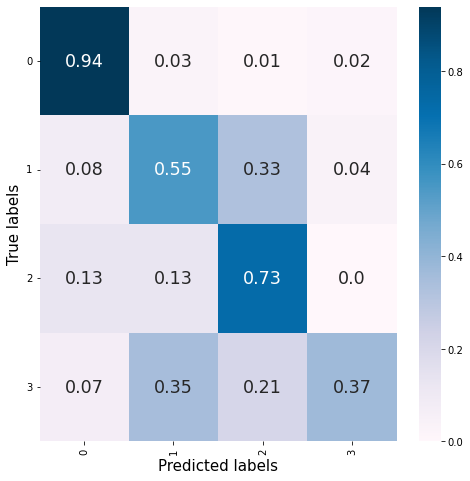

************Gender**********
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       255
           1       0.38      0.42      0.40        45

    accuracy                           0.81       300
   macro avg       0.64      0.65      0.64       300
weighted avg       0.82      0.81      0.81       300



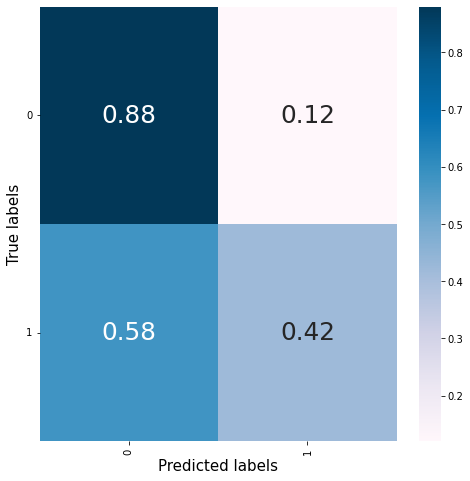

************Abdomen**********
              precision    recall  f1-score   support

           0       1.00      0.08      0.15        24
           1       0.33      0.06      0.10        18
           2       0.82      1.00      0.90       243
           3       0.00      0.00      0.00        15

    accuracy                           0.82       300
   macro avg       0.54      0.28      0.29       300
weighted avg       0.76      0.82      0.75       300



/home/venkat/anaconda3/envs/multihead/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/venkat/anaconda3/envs/multihead/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/venkat/anaconda3/envs/multihead/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

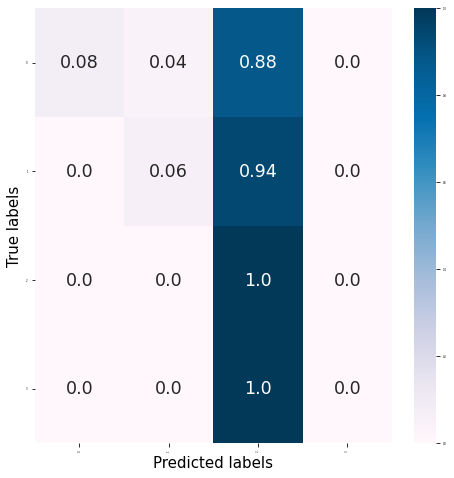

In [17]:
%matplotlib inline
test(last_checkpoint_path)